# Association rules mining.  Data preprocessing

Preparing and understanding transactional data for Market Basket Analysis (MBA): Apriori algorithm and building Tableau dashboards that show frequency, support, confidence, and lift for dish co-occurrences.



In [ ]:
!pip install --upgrade kagglehub

In [4]:
import pandas as pd
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [5]:
# Load the latest version
orders_raw = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "henslersoftware/19560-indian-takeaway-orders/versions/4",
  "restaurant-2-orders.csv",
)
'''
items_raw = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "henslersoftware/19560-indian-takeaway-orders/versions/4",
  "restaurant-2-products-price.csv",
)
'''

Using Colab cache for faster access to the '19560-indian-takeaway-orders' dataset.


'\nitems_raw = kagglehub.dataset_load(\n  KaggleDatasetAdapter.PANDAS,\n  "henslersoftware/19560-indian-takeaway-orders/versions/4",\n  "restaurant-2-products-price.csv",\n)\n'

In [6]:
orders_raw.head()

,Order ID,Order Date,Item Name,Quantity,Product Price,Total products
0,25583,03/08/2019 21:58,Tandoori Mixed Grill,1,11.95,12
1,25583,03/08/2019 21:58,Madras Sauce,1,3.95,12
2,25583,03/08/2019 21:58,Mushroom Rice,2,3.95,12
3,25583,03/08/2019 21:58,Garlic Naan,1,2.95,12
4,25583,03/08/2019 21:58,Paratha,1,2.95,12


In [7]:
#No missing values
orders_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119183 entries, 0 to 119182
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Order ID        119183 non-null  int64  
 1   Order Date      119183 non-null  object 
 2   Item Name       119183 non-null  object 
 3   Quantity        119183 non-null  int64  
 4   Product Price   119183 non-null  float64
 5   Total products  119183 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 5.5+ MB


In [ ]:
# ~ 20k orders in the dataset
print(len(orders_raw['Order ID'].unique()))

19658


In [8]:
orders = orders_raw.copy()

## Standarazing Dish Names

In [9]:
print(len(orders_raw['Item Name'].unique()))

337


In [10]:
# Lowercase everything
orders['Item Name'] = orders['Item Name'].str.lower()

# Remove spaces at the beginning and at the end
orders['Item Name'] = orders['Item Name'].str.strip()

# Replace multiple spaces with single
orders['Item Name'] = orders['Item Name'].str.replace(r'\s+', ' ', regex=True)

In [11]:
print(len(orders['Item Name'].unique()))

302


In [12]:
# Delete dash symbol
orders['Item Name'] = orders['Item Name'].str.replace('-', ' ', regex=False)

# Collapse multiple spaces into one
orders['Item Name'] = orders['Item Name'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [ ]:
print(len(orders['Item Name'].unique()))

279


In [13]:
# To review the results and see if we've missed something
menu = pd.Series(sorted(orders['Item Name'].unique()))
menu.to_csv("menu_items.csv", index=False)

In [14]:
# Manual replacement for common variants:
replace_dict = {
    'cobra ( large )': 'cobra',
    'cobra (330ml)': 'cobra',
    'cobra (660ml)': 'cobra',
    'chicken shaslick' : 'chicken shashlick',
    'graps specil' : 'grapes special',
    'king prawn shaslick' : 'king prawn shashlick',
    'kurma' : 'korma',
    'kurma sauce' : 'korma sauce',
    'lamb shaslick' : 'lamb shashlick',
    'paneer shaslick' :'paneer shashlick',
    'sheek kebab': 'sheek kebab'
}
orders['Item Name'] = orders['Item Name'].replace(replace_dict)

In [15]:
print(len(orders['Item Name'].unique()))

272


After cleaning, the menu was reduced from 337 to 272 unique items. Dish names had lots of errors due to mispelling, dash symbols, spaces and mixed lower and uppercases.

## Handling Duplicates

In [16]:
orders.duplicated().sum()

np.int64(178)

In [17]:
# Exact raw duplicates are removed, keeping only the first occurances
orders = orders.drop_duplicates(keep='first')

There are some orders that have multiple entries of the same dish.  Sometimes there may be small differences in timestamp or price (delivery fee, special pricing, etc.). Some customers also may ordered more than one portion of the same dish, but instead of recording Quantity, the dataset stored separate rows.  Order time or price are not of value for the further analysis, so we consolidate duplicates by grouping at the (Order ID, Item Name) level and summing their quantities into a single line per dish.

In [18]:
# Orders that have multiple entries of the same dish
orders.loc[orders.duplicated(subset=['Order ID','Item Name'], keep=False)].sort_values(by='Order ID')

,Order ID,Order Date,Item Name,Quantity,Product Price,Total products
109291,4595,01/06/2016 19:34,madras,1,8.95,13
88067,4595,01/06/2016 19:34,madras,1,7.95,13
88039,4702,10/06/2016 19:04,curry,2,7.95,9
88040,4702,10/06/2016 19:04,curry,1,7.95,9
63018,5187,18/08/2016 19:49,cobra,1,3.95,5
...,...,...,...,...,...,...
53562,18089,11/08/2018 19:07,cobra,1,3.95,7
50953,21402,19/01/2019 15:19,cobra,1,3.95,8
68814,21402,19/01/2019 15:19,cobra,1,5.50,8
68773,23997,18/05/2019 19:50,cobra,1,5.50,8


In [19]:
orders = (
    orders.groupby(['Order ID', 'Item Name'], as_index=False)
    .agg({'Quantity': 'sum'})
)

print("Before:", len(orders_raw))
print("After:", len(orders))

Before: 119183
After: 118876


In [20]:
#example of how one order is stored now
orders.loc[orders['Order ID'] == 4702]

,Order ID,Item Name,Quantity
1293,4702,bombay aloo,1
1294,4702,chicken balti,1
1295,4702,curry,3
1296,4702,green salad,1
1297,4702,mini bhaji,1
1298,4702,naan,3
1299,4702,pilau rice,1
1300,4702,plain rice,2


## Basic Statistics

Before mining rules, we verify data suitability: most orders (> 97%) include at least two items. This ensures sufficient co-occurrence to discover meaningful association rules.

In [21]:
# Total number of unique orders
total_orders = orders['Order ID'].nunique()

# Count how many unique dishes per order
dishes_per_order = (
    orders.groupby('Order ID')['Item Name']
    .nunique()
    .reset_index(name='num_dishes')
)

# Orders with multiple dish types
multi_orders = dishes_per_order[dishes_per_order['num_dishes'] > 1]['Order ID'].nunique()

# Share (percentage)
share = multi_orders / total_orders * 100

print("Total orders:", total_orders)
print("Orders with multiple dish types:", multi_orders)
print(f"Share of multi-dish orders: {share:.2f}%")

Total orders: 19658
Orders with multiple dish types: 19194
Share of multi-dish orders: 97.64%


In [22]:
dishes_per_order.head()

,Order ID,num_dishes
0,2096,7
1,4487,10
2,4488,5
3,4489,3
4,4490,4


In [23]:
# Basic stats
print(dishes_per_order['num_dishes'].describe())

# Frequency table
print(dishes_per_order['num_dishes'].value_counts().sort_index())

count    19658.000000
mean         6.047207
std          2.669461
min          1.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         29.000000
Name: num_dishes, dtype: float64
num_dishes
1      464
2      595
3     1629
4     3262
5     3417
6     3071
7     2216
8     1756
9     1190
10     822
11     530
12     314
13     168
14      87
15      55
16      34
17      15
18      12
19       7
20       5
21       2
22       1
23       1
24       3
25       1
29       1
Name: count, dtype: int64


We can see already that most orders contain 3-8 dishes. With the average of 6 dishes per order. About 25% of orders had 4 or fewer dishes and another 25% had more than 8 dishes. The biggest one had 29 dishes.

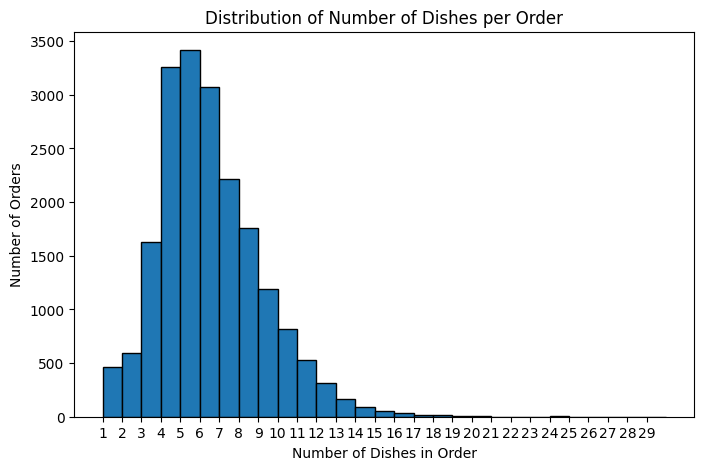

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(dishes_per_order['num_dishes'], bins=range(1, dishes_per_order['num_dishes'].max()+2), edgecolor='black')
plt.title("Distribution of Number of Dishes per Order")
plt.xlabel("Number of Dishes in Order")
plt.ylabel("Number of Orders")
plt.xticks(range(1, dishes_per_order['num_dishes'].max()+1))
plt.show()

- Most orders fall between 3 and 8 dishes, with a strong peak around 5–6 dishes.

- There are very few single-dish orders, meaning we have plenty of co-occurances.

- A small number of large orders (15+ dishes) exist — these could be catering or party orders.

In [31]:
# How many orders have a particular dish
dish_counts = orders['Item Name'].value_counts()

dish_counts

,count
Item Name,
pilau rice,8370
naan,6679
plain papadum,6431
bombay aloo,4128
garlic naan,3920
...,...
cylon prawn,2
rogon king prawn,1
bombay prawn,1


The restaurant offers around 270 unique dishes (including variations). Some of them are extremely unpopular, ordered only once, while others are highly popular with thousands of orders.

To focus on meaningful items, we set a threshold of 200 orders. Since the dataset contains ~20,000 orders in total, this threshold corresponds to a support level of 1% — meaning a dish must appear in at least 200 orders to be considered significant.

In [36]:
low_support_dishes = dish_counts[dish_counts < 200]
low_support_dishes.to_csv("unpopular_items.csv")
low_support_dishes

,count
Item Name,
methi,197
puree,196
king prawn puree,195
garlic chicken rice,195
curry lamb,187
...,...
cylon prawn,2
rogon king prawn,1
bombay prawn,1


Out of nearly 270 dishes, only 114 appear in more than 1% of all orders. This means that over half of the menu consists of items that are rarely chosen. Clearly, the restaurant could benefit from menu optimization by removing or replacing the extremely unpopular dishes and focusing on the ones that customers actually order.

In [ ]:
orders.to_csv('takeaway_orders',index=False)